In [12]:
from netCDF4 import Dataset
import tensorflow as tf
from datetime import datetime
import pandas as pd 
import tensorflow as tf
import gc 
import gzip
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import os 
# 检查可用GPU数量
len(tf.config.experimental.list_physical_devices('GPU'))


0

In [13]:
#读取数据
data = nc.Dataset(r'2009_2020Monthly_Data_025deg.nc')# GLORYS12V1 ocean reanalysis dataset
data_ssw = nc.Dataset(r'2009_2020Monthly_Raw_SSW.nc')#ERA5 surface wind stress dataset
#提取变量
ssh = data['zos'][12:144, 0:108, 0:168].data #sea_surface_height_above_geoid
so = data['so'][12:144,:, 0:108, 0:168].data #sea_water_salinity
thetao = data['thetao'][12:144,:, 0:108, 0:168].data #sea_water_potential_temperature
depth = data['depth'][:].data
lon = data['longitude'][4:164].data
lat =  data['latitude'][4:104].data
ussw = data_ssw['u'][12:144,:,0:108, 0:168].data
ussw = np.squeeze(ussw)
vssw = data_ssw['v'][12:144,:,0:108, 0:168].data
vssw = np.squeeze(vssw)
print(ssh.shape,so.shape,thetao.shape,depth.shape,lon.shape,lat.shape)
print(ussw.shape,vssw.shape)

(132, 108, 168) (132, 50, 108, 168) (132, 50, 108, 168) (50,) (160,) (100,)
(132, 108, 168) (132, 108, 168)


In [14]:
depth = np.round(depth, 1)
# print(depth)
print(", ".join(f"{x:.1f}" for x in depth))

0.5, 1.5, 2.6, 3.8, 5.1, 6.4, 7.9, 9.6, 11.4, 13.5, 15.8, 18.5, 21.6, 25.2, 29.4, 34.4, 40.3, 47.4, 55.8, 65.8, 77.9, 92.3, 109.7, 130.7, 155.9, 186.1, 222.5, 266.0, 318.1, 380.2, 453.9, 541.1, 643.6, 763.3, 902.3, 1062.4, 1245.3, 1452.3, 1684.3, 1941.9, 2225.1, 2533.3, 2865.7, 3220.8, 3597.0, 3992.5, 4405.2, 4833.3, 5274.8, 5727.9


In [15]:
sst = np.squeeze(thetao[:,0:1,0:108, 0:168])
sss = np.squeeze(so[:,0:1,0:108, 0:168])
print(sst.shape,sss.shape)

(132, 108, 168) (132, 108, 168)


In [16]:
depths = [0.5, 1.5, 2.6, 3.8, 5.1, 6.4, 7.9, 9.6, 11.4, 13.5, 15.8, 18.5, 21.6, 25.2, 29.4, 34.4, 40.3, 47.4, 55.8, 65.8, 77.9, 92.3, 109.7, 130.7, 155.9, 186.1, 222.5, 266.0, 318.1, 380.2, 
          453.9, 541.1, 643.6, 763.3, 902.3, 1062.4, 1245.3, 1452.3, 1684.3, 1941.9, 2225.1, 2533.3, 2865.7, 3220.8, 3597.0, 3992.5, 4405.2, 4833.3, 5274.8, 5727.9]
depths_use = [18.5, 40.3, 65.8, 77.9, 92.3, 109.7, 130.7, 155.9, 186.1, 222.5, 266.0, 318.1, 380.2, 453.9, 541.1, 643.6, 763.3, 902.3, 1062.4]

st = thetao[:,4:5]#即5.1m深处以及depths_use的深处的st

for i,depth in enumerate(depths):
    if(depth in depths_use):
        #print(depths[i])
        st = np.concatenate((st,thetao[:,i:i+1]),axis=1)   

st = st[:,:,4:104,4:164]
print(st.shape)  

(132, 20, 100, 160)


# 异常值筛选

In [17]:
# 海表异常值筛选

def physical_range_check(variable, var_name, valid_range):
    """
    物理范围检查函数
    :param variable: 要检查的numpy数组
    :param var_name: 变量名称(用于输出信息)
    :param valid_range: (min, max)元组
    :return: 处理后的数组，超出范围的值设为np.nan
    """
    min_val, max_val = valid_range
    original_shape = variable.shape
    
    # 展平数组以便计算
    flat_var = variable.reshape(-1)
    
    # 找出超出范围的值
    invalid_mask = (flat_var < min_val) | (flat_var > max_val)
    n_invalid = np.sum(invalid_mask)
    
    if n_invalid > 0:
        print(f"{var_name} - 发现 {n_invalid} 个超出范围的值 "
              f"(占总数据 {100*n_invalid/len(flat_var):.2f}%)")
        
        # 替换为NaN
        flat_var[invalid_mask] = np.nan

    return flat_var.reshape(original_shape)

# 定义各变量的合理物理范围
ranges = {
    'ssh': (-3, 3),          # 海面高度异常(米)
    'sss': (0, 40),           # 盐度(PSU)
    'sst': (-2, 40),      # 位温(摄氏度)
    'ussw': (-50, 50),       # 风速U分量(m/s)
    'vssw': (-50, 50)        # 风速V分量(m/s)
}
time_size, lat_size, lon_size = ssh.shape
# 对各变量执行范围检查
ssh_checked = physical_range_check(ssh, '海面高度(ssh)', ranges['ssh'])
sss_checked = physical_range_check(sss, '海面盐度(sss)', ranges['sss'])
sst_checked = physical_range_check(sst, '海面温度(thetao)', ranges['sst'])
ussw_checked = physical_range_check(ussw, '风速U分量(ussw)', ranges['ussw'])
vssw_checked = physical_range_check(vssw, '风速V分量(vssw)', ranges['vssw'])

cat_data =np.stack((ssh_checked,sss_checked,ussw_checked,vssw_checked,sst_checked),axis=3)
cat_data.shape

(132, 108, 168, 5)

In [18]:
# 海温异常值筛选

def check_temperature_by_depth(st, depths_used):
    """
    基于深度的温度范围检查 (优化版)
    参考WOA的气候态数据
    参数:
        st: 温度数据 (time, depth, lat, lon)
        depths_used: 使用的深度列表
    返回:
        处理后的温度数据
    """
    # 定义深度-温度范围 (可根据研究区域调整)
    depth_temp_ranges = {
        # 深度: (最低温度, 最高温度)
        5.1: (3, 32),     # 表层
        18.5: (3, 32),  
        40.3: (3, 32),
        65.8: (2, 32),
        77.9: (2, 32),
        92.3: (2, 32),
        109.7: (1, 32),
        130.7: (1, 32),
        155.9: (1, 30),
        186.1: (0, 26),
        222.5: (0, 26),
        266.0: (0, 22),
        318.1: (0, 20),
        380.2: (0, 20),
        453.9: (0, 18),
        541.1: (0, 17),
        643.6: (0, 14),
        763.3: (0, 11),
        902.3: (0, 8),
        1062.4: (0, 6)
    }
    
    total_invalid = 0
    
    # 检查每个深度层
    for i, depth in enumerate([5.1] + depths_used):
        if depth in depth_temp_ranges:
            min_temp, max_temp = depth_temp_ranges[depth]
            
            # 当前深度的温度数据
            temp_data = st[:, i, :, :]
            
            # 找出超出范围的值
            invalid_mask = (temp_data < min_temp) | (temp_data > max_temp)
            n_invalid = np.sum(invalid_mask)
            total_invalid += n_invalid
            
            if n_invalid > 0:
                # 将异常值设为NaN
                temp_data[invalid_mask] = np.nan
                st[:, i, :, :] = temp_data
    
    return st

st = check_temperature_by_depth(st, depths_use)
st = np.transpose(st,(0,2,3,1))

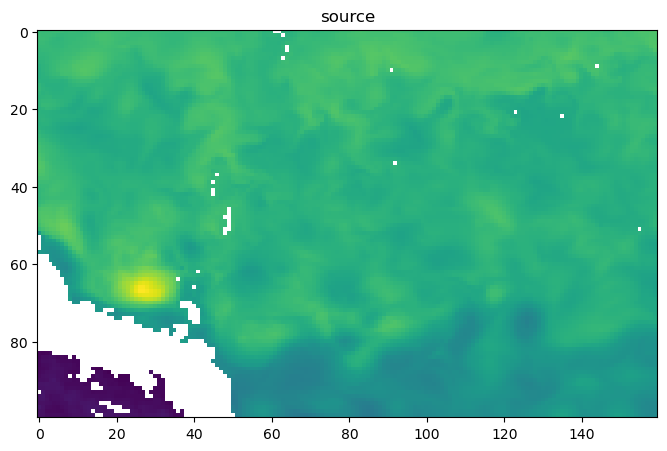

In [19]:
plt.figure(figsize=(8, 6), dpi = 100)
plt.imshow(st[10,:,:,18])              
plt.title('source')
plt.show()

In [20]:
data_surface_processed = cat_data 
data_st_processed = st

print(data_surface_processed.shape)
print(data_st_processed.shape)
np.save(r'data_surface_processed_2009_2020.npy',data_surface_processed)
np.save(r'data_st_processed_2009_2020.npy',data_st_processed)

(132, 108, 168, 5)
(132, 100, 160, 20)


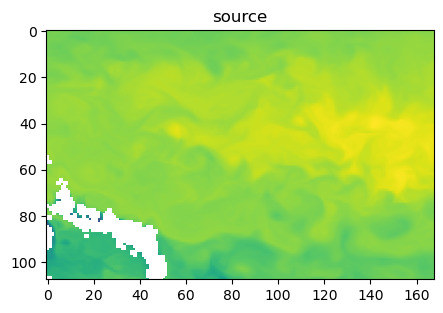

In [21]:
plt.figure(figsize=(5, 3.6), dpi = 100)
plt.imshow(data_surface_processed[130,:,:,1])              
plt.title('source')
plt.show()

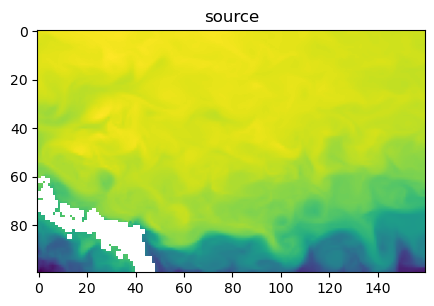

In [22]:
plt.figure(figsize=(5, 3.6), dpi = 100)
plt.imshow(data_st_processed[128,:,:,0])              
plt.title('source')
plt.show()